In [1]:
!pip install mediapy gamepy moviepy numpy gym==0.26.0 matplotlib

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 710.3/710.3 kB 17.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.6 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.26.0-py3-none-any.whl size=826270 sha256=9067c5c218cf4cebe4085d0e75b595c58243e00a99a5765189377f3df1a873cb
  Stored in directory: /root/.cache/pip/wheels/cd/da/7c/a034980e59e34687bfb6cfa3a5f3e9b389264a0c59519c59fa
  Created wheel for gamepy: filename=gamepy-0.1.5-py3-none-any.whl size=4273 sha256=c9a8d8b9f9f8c94292998979d24de64e4ba6a643362c85e6fa0bfe204f232b55
  Stored in directory: /root/.cache/pip/wheels/27/58/8d/bf946d3d1e5e4d37a47b862e607be93f1343e1a750f436e9c0
Successfully built gym gamepy
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully unins

### Q-Learning

In [2]:
import gym,time
from gym import envs
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import mediapy as media
from moviepy.video.io.bindings import mplfig_to_npimage
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
np.set_printoptions(precision=2,suppress=True)
plt.rc('xtick',labelsize=8); plt.rc('ytick',labelsize=8)
print ("gym:[%s]"%(gym.__version__))
print ("numpy:[%s]"%(np.__version__))
print ("matplotlib:[%s]"%(matplotlib.__version__))

gym:[0.26.0]
numpy:[1.23.5]
matplotlib:[3.7.1]


Helper functions

In [3]:
def plot_env(env,figsize=(4,4),title_str=None,title_fs=10,
             PLOT_IMG=True,RETURN_IMG=False):
    img = env.render()
    fig = plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.axis('off')
    if title_str is not None:
        plt.title(title_str,fontsize=title_fs)
    if PLOT_IMG:
        plt.show()
    # (Optional) Get image
    if RETURN_IMG:
        img = mplfig_to_npimage(fig)
        plt.close()
        return img
print ("Ready.")

def visualize_matrix(M,strs='',figsize=(4,4),fontsize=10,
                     cmap='turbo',title='Title',title_fs=10,subplots_top=1.05,
                     REMOVE_TICK_LABELS=True,PLOT_IMG=True,RETURN_IMG=False):
    """
    Visualize a matrix colors and strings
    """
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    n_row,n_col = M.shape[0],M.shape[1]

    fig,ax = plt.subplots(figsize=figsize)
    divider = make_axes_locatable(ax)
    im = ax.imshow(M,cmap=plt.get_cmap(cmap),extent=(0,n_col,n_row,0),
              interpolation='nearest',aspect='equal')
    ax.set_xticks(np.arange(0,n_col,1))
    ax.set_yticks(np.arange(0,n_row,1))
    ax.grid(color='w', linewidth=2)
    ax.set_frame_on(False)
    x,y = np.meshgrid(np.arange(0,n_col,1.0),np.arange(0,n_row,1.0))
    if len(strs) == n_row*n_col:
        idx = 0
        for x_val,y_val in zip(x.flatten(), y.flatten()):
            c = strs[idx]
            idx = idx + 1
            ax.text(x_val+0.5,y_val+0.5,c,va='center', ha='center',size=fontsize)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    fig.suptitle(title,size=title_fs)
    fig.tight_layout()
    fig.subplots_adjust(top=subplots_top)
    if REMOVE_TICK_LABELS:
        plt.setp(ax.get_xticklabels(),visible=False)
        plt.setp(ax.get_yticklabels(),visible=False)
    if PLOT_IMG:
        plt.show()
    if RETURN_IMG:
        img = mplfig_to_npimage(fig)
        plt.close()
        return img

def display_q_value(Q,figsize=(5,5),title="Q Function",title_fs=10,text_fs=5):
    """
    Display Q value
    """
    n_state, n_action = Q.shape
    nRow = 8
    # Triangle patches for each action
    lft_tri = np.array([[0,0],[-0.5,-0.5],[-0.5,0.5]])
    dw_tri = np.array([[0,0],[-0.5,0.5],[0.5,0.5]])
    up_tri = np.array([[0,0],[0.5,-0.5],[-0.5,-0.5]])
    rgh_tri = np.array([[0,0],[0.5,0.5],[0.5,-0.5]])
    # Color
    high_color = np.array([1.0, 0.0, 0.0, 0.8])
    low_color  = np.array([1.0, 1.0, 1.0, 0.8])
    fig = plt.figure(figsize=figsize)
    plt.title(title,fontsize=title_fs)
    for i in range(nRow):
        for j in range(nRow):
            s = i*nRow+j
            min_q = np.min(Q[s])
            max_q = np.max(Q[s])
            for a in range(n_action):
                q_value = Q[s,a]
                ratio = (q_value - min_q)/(max_q - min_q + 1e-10)
                if ratio > 1: clr = high_color
                elif ratio < 0: clr = low_color
                else: clr = high_color*ratio + low_color*(1-ratio)
                if a == 0: # Left arrow
                    plt.gca().add_patch(plt.Polygon([j,i]+lft_tri, color=clr, ec='k'))
                    plt.text(j-0.25, i+0.0,"%.2f"%(q_value),fontsize=text_fs,va='center', ha='center')
                if a == 1: # Down arrow
                    plt.gca().add_patch(plt.Polygon([j,i]+dw_tri, color=clr, ec='k'))
                    plt.text(j-0.0, i+0.25,"%.2f"%(q_value),fontsize=text_fs,va='center', ha='center')
                if a == 2: # Right arrow
                    plt.gca().add_patch(plt.Polygon([j,i]+rgh_tri, color=clr, ec='k'))
                    plt.text(j+0.25, i+0.0,"%.2f"%(q_value),fontsize=text_fs,va='center', ha='center')
                if a == 3: # Up arrow
                    plt.gca().add_patch(plt.Polygon([j,i]+up_tri, color=clr, ec='k'))
                    plt.text(j-0.0, i-0.25,"%.2f"%(q_value),fontsize=text_fs,va='center', ha='center')
    plt.xlim([-0.5,nRow-0.5])
    plt.xticks(range(nRow))
    plt.ylim([-0.5,nRow-0.5])
    plt.yticks(range(nRow))
    plt.gca().invert_yaxis()
    plt.show()

print ("Ready.")

Ready.


### Q Learning
To implement model-free policy iteration, we need to estimate the followings using samples:

$Q_{k+1}(s,a) = \sum_{s'} \left[r(s,a,s') + \gamma \max_{a'} Q_{k}(s',a') \right] P(s'|s,a)$

Update Q value using temporal difference (TD) target and error:

$Q_{new}(S_{t}, A_{t}) \leftarrow Q_{old}(S_{t}, A_{t}) + \alpha (R_{t+1} + \gamma \max_{a'} Q_{old}(S_{t+1},a') - Q_{old}(S_{t}, A_{t}))$

We can update our estimator online, just $(S_{t},A_{t},R_{t+1},S_{t+1})$ is needed.
$A_{t+1}$ is not needed.

TD target is $R_{t+1} + \gamma \max_{a'} Q_{old}(S_{t+1},a')$

TD error is $R_{t+1} + \gamma \max_{a'} Q_{old}(S_{t+1},a') - Q(S_{t},A_{t})$

Algorithm
--
---
For every time step

Policy Evaluation

- Collect $(S_{t},A_{t},R_{t+1},S_{t+1})$

- $\text{TD target} = R_{t+1} + \gamma \max_{a'} Q_{old}(S_{t+1},a')$

- $\text{TD error} = R_{t+1} + \gamma \max_{a'} Q_{old}(S_{t+1},a') - Q(S_{t},A_{t})$

- $Q[S_{t}, A_{t}] = Q[S_{t}, A_{t}] + \alpha \text{TD target}$

Policy Improvement

- $\pi(a|s) = \frac{\epsilon}{m} + (1-\epsilon) \mathbf{1}\left(a = \max_{a'} Q(s,a')\right)$

In [4]:
class Q_learningAgent():
    def __init__(self,n_state,n_action,alpha=0.5,epsilon=1.0,gamma=0.999):
        self.n_state = n_state
        self.n_action = n_action
        self.alpha_init = alpha
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma

        # Initial Q value
        self.Q = np.zeros([n_state,n_action])

    def update_value(self,state,action,reward,state_prime,done):
        """
        Update value
        """
        Q_old = self.Q[state][action]
        # TD target
        if done:
            td_target = reward
        else:
            td_target = reward + self.gamma*np.max(self.Q[state_prime])
        td_error = td_target - Q_old # TD error
        self.Q[state,action] = Q_old + self.alpha*td_error # update Q

    def update_epsilon(self,epsilon):
        self.epsilon = np.min([epsilon,1.0])

    def update_alpha(self,alpha):
        self.alpha = np.min([alpha,self.alpha_init])

    def get_action(self,state):
        """
        Get action
        """
        if np.random.uniform() < self.epsilon:
            action = np.random.randint(0,high=self.n_action)
        else:
            action = np.argmax(self.Q[state])
        return action

print ("Ready.")

Ready.


### Q-Learning with random policy (10,000 episodes)

Q-learning done.


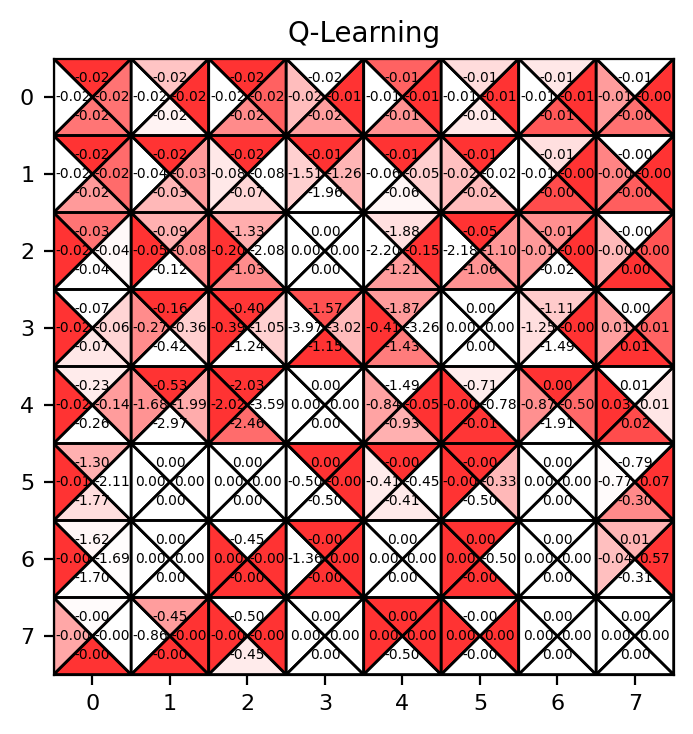

Return is [1.000] (tick:[101])


In [5]:
env = gym.make('FrozenLake8x8-v1',render_mode='rgb_array')
n_state = env.observation_space.n
n_action = env.action_space.n
Q = Q_learningAgent(n_state,n_action,epsilon=1.0,alpha=0.1,gamma=0.999) # epsilon=1.0 -> random policy
# Loop
n_episode = 1000
for e_idx in range(n_episode):
    state,_ = env.reset()
    action = Q.get_action(state)
    done = False
    while not done:
        state_prime,reward,done,truncated,info = env.step(action) # step
        if done:
            # Reward modification to handle sparse reward
            if reward == 0:
                reward = -5
            else:
                reward = +5
        else:
            reward = -0.001
        action_prime = Q.get_action(state_prime)
        Q.update_value(state, action, reward, state_prime, done)
        state = state_prime
        action = action_prime
    Q.update_alpha(1000/(e_idx+1)) # reduce update rate
print ("Q-learning done.")
display_q_value(Q.Q, title="Q-Learning",figsize=(4,4),title_fs=10,text_fs=5)
# Animate learned policy
obs,_ = env.reset()
gamma = 0.99
ret,frames = 0,[]
for tick in range(1000):
    action = np.argmax(Q.Q[obs])
    next_obs,reward,done,truncated,info = env.step(action)
    # Render
    title_str = "tick:[%d] action:[%s] reward:[%.2f] done:[%d]"%(
        tick,action,reward,done
    )
    img = plot_env(env,figsize=(4,4),title_str=title_str,title_fs=8,
                   PLOT_IMG=False,RETURN_IMG=True)
    frames.append(img)
    obs = next_obs
    ret = reward + gamma*ret
    if done: break
env.close()
print ("Return is [%.3f] (tick:[%d])"%(ret,tick))
media.show_video(frames, fps=5)

### Q-Learning with random policy (1,000 episodes)

Q-learning done.


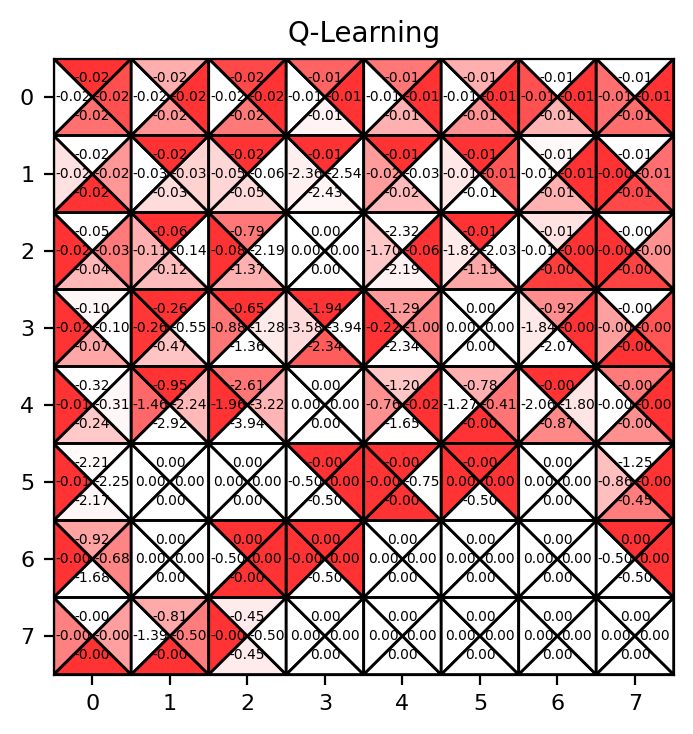

Return is [1.000] (tick:[76])


In [6]:
env = gym.make('FrozenLake8x8-v1',render_mode='rgb_array')
n_state = env.observation_space.n
n_action = env.action_space.n
Q = Q_learningAgent(n_state,n_action,epsilon=1.0,alpha=0.1,gamma=0.999) # epsilon=1.0 -> random policy
# Loop
n_episode = 1000
for e_idx in range(n_episode):
    state,_ = env.reset()
    action = Q.get_action(state)
    done = False
    while not done:
        state_prime,reward,done,truncated,info = env.step(action) # step
        if done:
            # Reward modification to handle sparse reward
            if reward == 0:
                reward = -5
            else:
                reward = +5
        else:
            reward = -0.001
        action_prime = Q.get_action(state_prime)
        Q.update_value(state, action, reward, state_prime, done)
        state = state_prime
        action = action_prime
    Q.update_alpha(1000/(e_idx+1)) # reduce update rate
print ("Q-learning done.")
display_q_value(Q.Q, title="Q-Learning",figsize=(4,4),title_fs=10,text_fs=5)
# Animate learned policy
obs,_ = env.reset()
gamma = 0.99
ret,frames = 0,[]
for tick in range(1000):
    action = np.argmax(Q.Q[obs])
    next_obs,reward,done,truncated,info = env.step(action)
    # Render
    title_str = "tick:[%d] action:[%s] reward:[%.2f] done:[%d]"%(
        tick,action,reward,done
    )
    img = plot_env(env,figsize=(4,4),title_str=title_str,title_fs=8,
                   PLOT_IMG=False,RETURN_IMG=True)
    frames.append(img)
    obs = next_obs
    ret = reward + gamma*ret
    if done: break
env.close()
print ("Return is [%.3f] (tick:[%d])"%(ret,tick))
media.show_video(frames, fps=5)

### Q-Learning with epsilon-greedy policy (1,000 episodes)

Q-learning done.


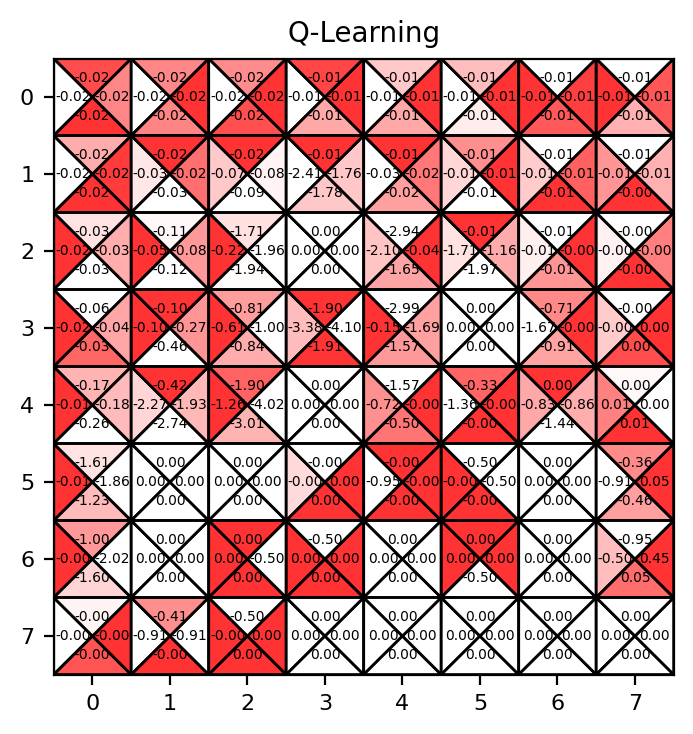

Return is [1.000] (tick:[91])


In [ ]:
env = gym.make('FrozenLake8x8-v1',render_mode='rgb_array')
n_state = env.observation_space.n
n_action = env.action_space.n
Q = Q_learningAgent(n_state,n_action,epsilon=1.0,alpha=0.1,gamma=0.999) # epsilon=1.0 -> random policy
# Loop
n_episode = 1000
for e_idx in range(n_episode):
    state,_ = env.reset()
    action = Q.get_action(state)
    done = False
    while not done:
        state_prime,reward,done,truncated,info = env.step(action) # step
        if done:
            # Reward modification to handle sparse reward
            if reward == 0:
                reward = -5
            else:
                reward = +5
        else:
            reward = -0.001
        action_prime = Q.get_action(state_prime)
        Q.update_value(state, action, reward, state_prime, done)
        state = state_prime
        action = action_prime
    Q.update_alpha(1000/(e_idx+1)) # reduce update rate
    Q.update_epsilon(1000/(e_idx+1)) # reduce randomness
print ("Q-learning done.")
display_q_value(Q.Q, title="Q-Learning",figsize=(4,4),title_fs=10,text_fs=5)
# Animate learned policy
obs,_ = env.reset()
gamma = 0.99
ret,frames = 0,[]
for tick in range(1000):
    action = np.argmax(Q.Q[obs])
    next_obs,reward,done,truncated,info = env.step(action)
    # Render
    title_str = "tick:[%d] action:[%s] reward:[%.2f] done:[%d]"%(
        tick,action,reward,done
    )
    img = plot_env(env,figsize=(4,4),title_str=title_str,title_fs=8,
                   PLOT_IMG=False,RETURN_IMG=True)
    frames.append(img)
    obs = next_obs
    ret = reward + gamma*ret
    if done: break
env.close()
print ("Return is [%.3f] (tick:[%d])"%(ret,tick))
media.show_video(frames, fps=5)